# Case study for Oetelshofen Surface Mine - Cloud coverage statistics
This notebook is part of a series of notebooks for a case study of the Oetelshofen Surface Mine. In this notebook, we look at the historical cloud cover statistics for the Oetelshofen mine.

## Configuration and imports

In [1]:
from sentinelhub import SHConfig

config = SHConfig("sentinel-hub-dida-testing")

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    SentinelHubCatalog,
    bbox_to_dimensions,
)

from amoki.config import DATA_DIR, REFERENCES_DIR
from amoki.utilities.sentinelhub_utils import plot_image, get_cloud_coverage

## Setting area of interest
The bounding box for the Oetelshofen surface mine (one of the biggest open mines in Germany) in `WGS84` coordinate system is approximately `[7.0267, 51.2328, 7.0526, 51.2486]` (longitude and latitude coordinates of lower left and upper right corners). You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

In [3]:
oetelshofen_coords_wgs84 = (7.0267, 51.2328, 7.0526, 51.2486)


When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [4]:
resolution = 10
oetelshofen_bbox = BBox(bbox=oetelshofen_coords_wgs84, crs=CRS.WGS84)
oetelshofen_size = bbox_to_dimensions(oetelshofen_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {oetelshofen_size} pixels")

Image shape at 10 m resolution: (185, 171) pixels


## First example of cloud coverage data request
Let's define an evalscript which will return Sentinel-2 cloud coverage data for the region of interest. 
There is probably room to optimise this, but since this is just an exploration notebook we won't do this here.

In [5]:
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["CLM"],
    output: { bands: 1 }
  }
}

function evaluatePixel(sample) {
  return [sample.CLM];
}
"""

In [6]:
request_clm = SentinelHubRequest(
    data_folder=DATA_DIR / "sentinel_testing" / "oetelshofen" / "clouds",
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-01-01", "2020-01-18"),
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.PNG),
        SentinelHubRequest.output_response("userdata", MimeType.JSON)
        ],
    bbox=oetelshofen_bbox,
    size=oetelshofen_size,
    config=config,
)

In [7]:
data_with_cloud_mask = request_clm.get_data(save_data=True)

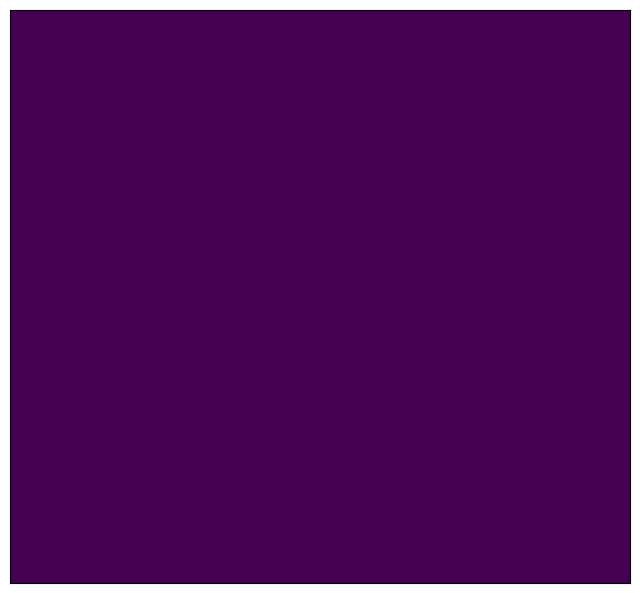

In [8]:
cloud_mask = data_with_cloud_mask[0]["default.png"]/255

plot_image(cloud_mask, figsize=(8,8))

In [9]:
get_cloud_coverage(cloud_mask=cloud_mask)

np.float64(1.0)

### Searching the catalog for available data
We can use the Catalog API to list available data for the requested area in the requested time interval. 

In [10]:
catalog = SentinelHubCatalog(config=config)

search_iterator = catalog.search(
  DataCollection.SENTINEL2_L1C,
  bbox=oetelshofen_bbox,
  time=('2020-03-01', '2020-03-31'),
)

results = list(search_iterator)

The catalog contains a lot of information. At the moment, we are just interested in the dates on which data is available. 

In [11]:
# Show the datetime results
dates_of_acquisition = sorted(list(set([result["properties"]["datetime"][0:10] for result in results])))
dates_of_acquisition

['2020-03-03',
 '2020-03-05',
 '2020-03-08',
 '2020-03-10',
 '2020-03-13',
 '2020-03-15',
 '2020-03-18',
 '2020-03-20',
 '2020-03-23',
 '2020-03-25',
 '2020-03-28',
 '2020-03-30']

We see that the revisit time for Sentinel 2 is about once every 3 days. Note that there are two Sentinel2 satellites, Sentinal2a and Sentinel2b. Individually, these have a revisit time of approximately 10 days, but they are staggered so that the acquisition time is approximately every 3 days. 

## Historical variation of cloud coverage
Let's get the cloud coverage for an entire year. We first search the catalog for the dates of acquistion during the time period.

In [12]:
catalog = catalog = SentinelHubCatalog(config=config)

search_iterator = catalog.search(
  DataCollection.SENTINEL2_L1C,
  bbox=oetelshofen_bbox,
  time=('2019-01-01', '2019-12-31'),
)

results = list(search_iterator)

In [13]:
# Show the datetime results
dates_of_acquisition = sorted(list(set([result["properties"]["datetime"][0:10] for result in results])))
print(f"We have data for this number of different days: {len(dates_of_acquisition)}")

# Define a one-day window for each date
acquisition_windows = [(date, date) for date in dates_of_acquisition]

We have data for this number of different days: 146


Note that 146 requests uses a lot of processing units, so consider whether you need to run this code before you do.

In [14]:
# Define a function to return a request given a time window

def get_clm_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_clm,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=oetelshofen_bbox,
        size=oetelshofen_size,
        config=config,
    )

In [15]:
# create a list of requests
list_of_requests = [get_clm_request(slot) for slot in acquisition_windows]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

In [16]:
# For each image collected, calculate the percentage of cloud cover in that image

cloud_stats = []

for (date, image) in zip(dates_of_acquisition, data):
    image = image/255
    cloud_coverage = get_cloud_coverage(image)
    formatted_date = datetime.datetime.strptime(date, '%Y-%m-%d').date()
    cloud_stats.append((formatted_date, get_cloud_coverage(image)))


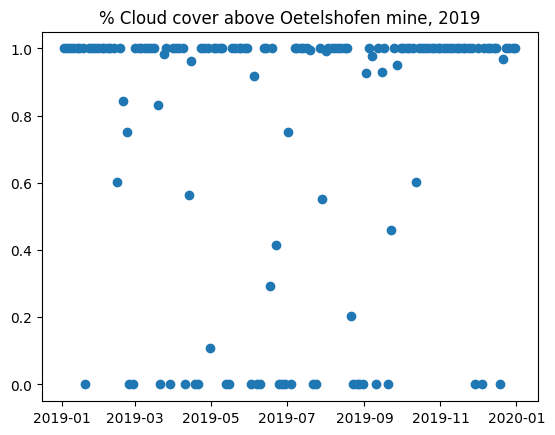

In [17]:
# Plot the percentage cloud cover over time
date, cloud_cover = zip(*cloud_stats)

plt.plot(date, cloud_cover, 'o')
plt.title("% Cloud cover above Oetelshofen mine, 2019")
plt.show()

In [18]:
# Average cloud cover is quite high
np.array(cloud_cover).mean()

np.float64(0.7642486754959718)

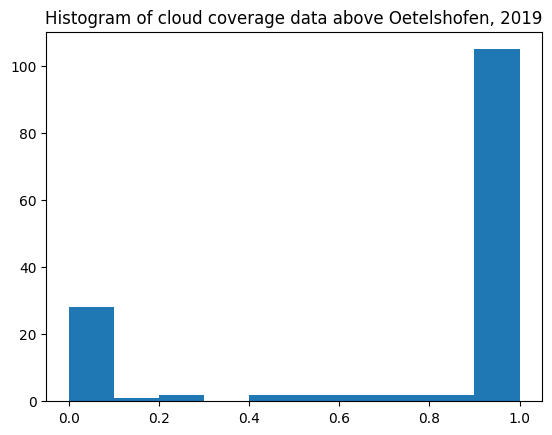

In [19]:
# We see that the image is often close to 100% covered in clouds.
plt.hist(cloud_cover, bins = 10)
plt.title("Histogram of cloud coverage data above Oetelshofen, 2019")
plt.show()